In [2]:
# ------------------------------------------------------------------------------ #
# @Author:        F. Paul Spitzner
# @Email:         paul.spitzner@ds.mpg.de
# @Created:       2023-10-09 16:49:35
# @Last Modified: 2023-10-09 16:49:42
# ------------------------------------------------------------------------------ #

%reload_ext autoreload
%autoreload 2
%reload_ext ipy_dict_hierarchy
%reload_ext watermark

import logging
logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

import re
import glob
import h5py
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import dask

import matplotlib.pyplot as plt
from tqdm import tqdm
from bitsandbobs.plt import set_size


# also needs to be added for each dask-worker
extra_path = os.path.abspath('../')
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")

# data_dir = "../../../gnode/experiment_analysis/dat/"
# data_dir = "../data"
# data_dir = "/data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data"
data_dir = os.path.abspath("/Users/paul/para/5_Archive/information_timescales/repo/gnode.nosync/experiment_analysis/dat")
os.makedirs("../img/", exist_ok=True)


2024-05-27 13:36:34,293 | INFO     | notebook | <module> | project directory: /Users/paul/para/5_Archive/information_timescales/repo/_latest/experiment_analysis


In [3]:
# load our results from timescale fitting
meta_df = pd.read_hdf(f"{data_dir}/all_units_merged_blocks_with_spont.h5", key="meta_df")

# add metrics from image selectivity etc.
meta_df = utl.load_metrics(meta_df.reset_index(), data_dir)
meta_df = utl.add_structure_and_hierarchy_scores(meta_df)
meta_df = meta_df.query("structure_name in ['V1', 'LM', 'RL', 'AL', 'PM', 'AM']")
meta_df

2024-05-27 13:36:39,928 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'g_dsi_dg', 'mod_idx_dg', 'on_screen_rf', 'image_selectivity_ns'] from /Users/paul/para/5_Archive/information_timescales/repo/gnode.nosync/experiment_analysis/dat/brain_observatory_unit_metrics_filtered.csv
2024-05-27 13:36:39,931 | DEBUG    | its_utility | load_metrics | Matched 6368 rows from meta_df in /Users/paul/para/5_Archive/information_timescales/repo/gnode.nosync/experiment_analysis/dat/brain_observatory_unit_metrics_filtered.csv


,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,tau_double,tau_R_details,tau_single_details,tau_double_details,g_dsi_dg,image_selectivity_ns,mod_idx_dg,on_screen_rf,structure_name,hierarchy_score
0,950911932,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1078.491211,8.025100,/project.nst/neuroscience-raw/Allen/visual_cod...,8655,...,0.748946,"{'firing_rate': 8.012090922999178, 'firing_rat...","{'tau': 5.404084198337884e-05, 'mre': 6.575654...","{'tau': 0.7489462162647652, 'mre': 0.993346188...",0.095447,0.164169,1.353636,False,AM,0.441
1,950911986,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1079.203369,3.647135,/project.nst/neuroscience-raw/Allen/visual_cod...,3936,...,1.874703,"{'firing_rate': 3.6471291367256455, 'firing_ra...","{'tau': 2.3026338728859774, 'mre': 0.997830929...","{'tau': 1.874703126979266, 'mre': 0.9973364645...",0.108358,0.017271,0.639408,False,AM,0.441
2,950912164,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1077.872803,8.500075,/project.nst/neuroscience-raw/Allen/visual_cod...,9162,...,1.026284,"{'firing_rate': 8.475008697669026, 'firing_rat...","{'tau': 1.0262833654998276, 'mre': 0.995139899...","{'tau': 1.0262836602024297, 'mre': 0.995139901...",0.228699,0.598220,1.030492,True,AM,0.441
3,950912190,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1075.171875,4.399297,/project.nst/neuroscience-raw/Allen/visual_cod...,4730,...,1.363502,"{'firing_rate': 4.395563512916502, 'firing_rat...","{'tau': 1.5642971952849982, 'mre': 0.996808779...","{'tau': 1.363502294341311, 'mre': 0.9963396881...",0.056741,0.348424,0.999923,True,AM,0.441
4,950912214,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1073.492432,5.326540,/project.nst/neuroscience-raw/Allen/visual_cod...,5718,...,0.377801,"{'firing_rate': 5.317211538013684, 'firing_rat...","{'tau': 0.6056864214354767, 'mre': 0.991778883...","{'tau': 0.37780093267583975, 'mre': 0.98685270...",0.069080,0.422288,0.219870,True,AM,0.441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17944,950942400,spontaneous,771160300,null,VISal,SUCCESS,1797.115234,0.377828,/project.nst/neuroscience-raw/Allen/visual_cod...,679,...,0.217925,"{'firing_rate': 0.36583331347267567, 'firing_r...","{'tau': 0.25702383931940154, 'mre': 0.98073454...","{'tau': 0.2179251442600049, 'mre': 0.977317546...",NaN,NaN,NaN,NaN,AL,0.152
17945,950944614,spontaneous,771160300,null,VISal,SUCCESS,1792.901855,0.377600,/project.nst/neuroscience-raw/Allen/visual_cod...,677,...,0.057439,"{'firing_rate': 0.38629086027452963, 'firing_r...","{'tau': 0.4395698459887982, 'mre': 0.988689691...","{'tau': 0.05743850656844875, 'mre': 0.91663161...",NaN,NaN,NaN,NaN,AL,0.152
17946,950943984,spontaneous,771160300,null,VISal,SUCCESS,1773.977051,0.135289,/project.nst/neuroscience-raw/Allen/visual_cod...,240,...,0.170986,"{'firing_rate': 0.13628681470096451, 'firing_r...","{'tau': 0.1709865057191234, 'mre': 0.971181338...","{'tau': 0.17098641292634262, 'mre': 0.97118132...",NaN,NaN,NaN,NaN,AL,0.152
17947,950942680,spontaneous,771160300,null,VISal,SUCCESS,1801.591797,12.195324,/project.nst/neuroscience-raw/Allen/visual_cod...,21971,...,0.068260,"{'firing_rate': 12.154834329411557, 'firing_ra...","{'tau': 0.08191797577480081, 'mre': 0.94078874...","{'tau': 0.06826005692776223, 'mre': 0.92936912...",NaN,NaN,NaN,NaN,AL,0.152


In [4]:
# sanity check, selectivity should be present for all units in natural_movie_three
assert (
    len(meta_df.query("stimulus == 'natural_movie_three'"))
    == np.isfinite(meta_df.query("stimulus == 'natural_movie_three'")["mod_idx_dg"]).sum()
)

# exclude nans for now ~ 5 rows with low rates and one todo for unit 951021415
len_before = len(meta_df)
meta_df = meta_df.query("R_tot == R_tot")
meta_df = meta_df.query("tau_R > 0.0")
meta_df = meta_df.query("tau_double > 0.0 & tau_double < 10.0")
# timescales above 10s are likely an inference problems,
# as we have 600 - 800 seconds of data. cf. https://arxiv.org/abs/2007.03367
len_after = len(meta_df)
log.info(f"removed {len_before - len_after} rows due to unexpected timescales")

2024-05-27 13:36:44,311 | INFO     | notebook | <module> | removed 995 rows due to unexpected timescales


2024-05-27 13:54:02,166 | INFO     | plot_helper | panel_stimulus_violins | violins for R_tot, ['natural_movie_one_more_repeats' 'spontaneous'], N=4200
2024-05-27 13:54:02,170 | INFO     | plot_helper | panel_stimulus_violins | natural_movie_one_more_repeats vs spontaneous diff=-22.8% diff_of_medians=-27.8% p=6.702008691529839e-202
2024-05-27 13:54:02,586 | DEBUG    | plot_helper | fancy_violins | natural_movie_one_more_repeats median: 0.0831 quantiles: [0.08142518 0.08494428] from 500 samples of length 4200
2024-05-27 13:54:02,586 | DEBUG    | plot_helper | fancy_violins | natural_movie_one_more_repeats min: 0.0056 max: 0.37
2024-05-27 13:54:02,987 | DEBUG    | plot_helper | fancy_violins | spontaneous median: 0.0651 quantiles: [0.06389428 0.06649921] from 500 samples of length 4200
2024-05-27 13:54:02,987 | DEBUG    | plot_helper | fancy_violins | spontaneous min: 0.001 max: 0.47
2024-05-27 13:54:02,994 | DEBUG    | plot_helper | fancy_violins | plotting 600 points for cat stimulus
2

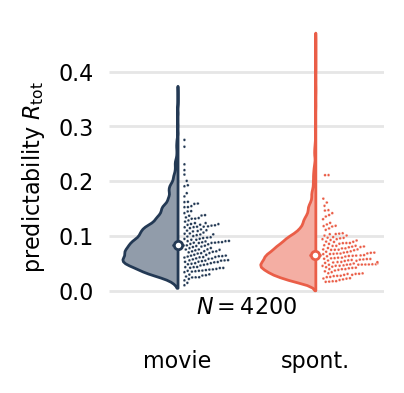

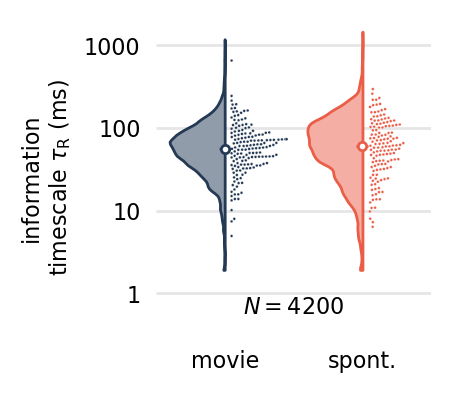

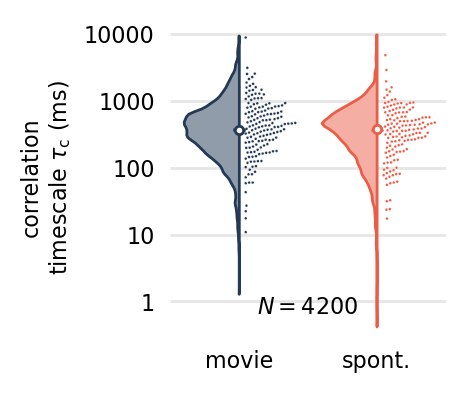

In [16]:
import matplotlib as mpl

with mpl.rc_context({"xtick.labelsize": 8, "axes.labelsize": 8}):
    for obs in ["R_tot", "tau_R", "tau_double"]:
    # for obs in ["R_tot"]:
        ax = ph.panel_stimulus_violins(
            df = meta_df.query("block in ['merged_3.0_and_8.0', 'null']"),
            observable = obs,
            logscale=False if obs == "R_tot" else True,
            category = "stimulus",
            num_swarm_points=300,
            seed=44,
            replace = False,
            same_points_per_swarm=True,
            xlabels = ['movie', 'spont.'],
            # specify palette to make sure labels are correct!
            palette={
                    "natural_movie_one_more_repeats" : "#233954",
                    "spontaneous" : "#EA5E48",
                },
            swarm_spacing = 1.2,
            swarm_kwargs=dict(
                size=1.0,
                linewidth=0.10,
            ),
        )
        set_size(ax, w=3.5, h=4.0)
        ax.get_figure().savefig(f"../img/fig4_violins_natural_movie_one_more_repeats_{obs}.pdf", dpi=300)


4200


(-0.15, 0.15)

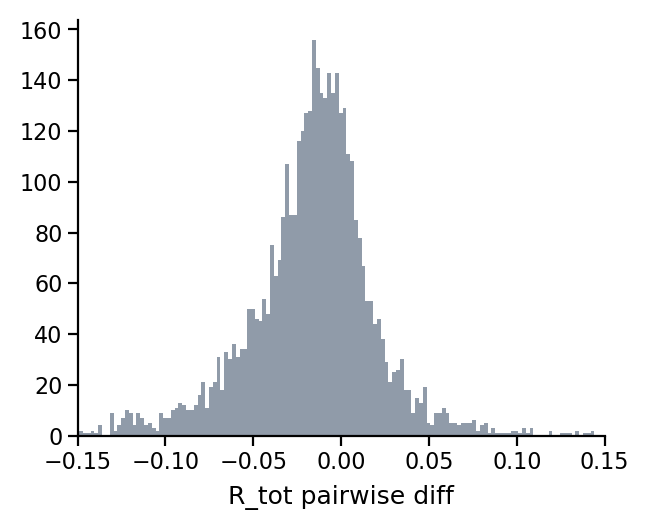

In [19]:
df = meta_df.query("block in ['merged_3.0_and_8.0', 'null']")

num_violins = 2
valid_units = df.groupby('unit_id').filter(lambda x: len(x) == num_violins)['unit_id'].unique()
df = df.query('unit_id in @valid_units')

df = df.query("block == 'null'")
print(len(df))

samples = ph._pd_bootstrap(
    df,
    obs="R_tot",
    num_boot=500,
    sample_size=len(df),
    f_within_sample=np.median,
)

# plt.hist(samples, bins=50, alpha=0.5);
plt.hist(ph.debug_diff, bins=250, alpha=0.5);
plt.xlabel("R_tot pairwise diff")
plt.xlim(-0.15, 0.15)

2024-05-27 13:36:48,489 | INFO     | plot_helper | panel_selectivity_scatter | dropped 0 rows with nan
2024-05-27 13:36:48,497 | INFO     | plot_helper | panel_selectivity_scatter | r: 0.346, p: 6.2e-134, m: 0.138, b: 0.069
2024-05-27 13:36:48,567 | INFO     | plot_helper | panel_selectivity_scatter | dropped 0 rows with nan
2024-05-27 13:36:48,575 | INFO     | plot_helper | panel_selectivity_scatter | r: -0.123, p: 1.4e-17, m: -48.941, b: 77.603
2024-05-27 13:36:48,643 | INFO     | plot_helper | panel_selectivity_scatter | dropped 0 rows with nan
2024-05-27 13:36:48,650 | INFO     | plot_helper | panel_selectivity_scatter | r: -0.142, p: 6.3e-23, m: -1001.625, b: 775.987


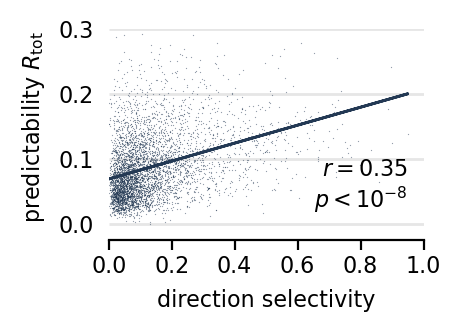

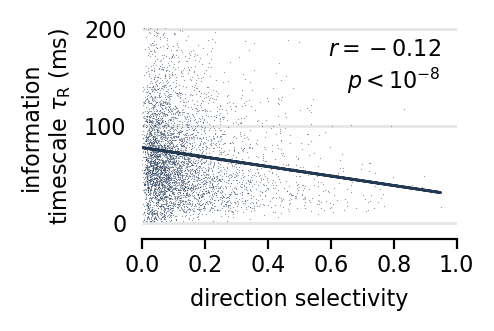

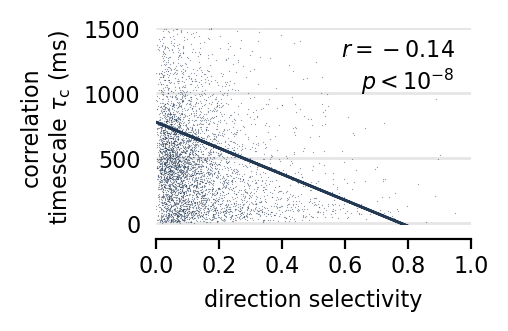

In [30]:

with mpl.rc_context({"xtick.labelsize": 8, "axes.labelsize": 8, "font.size": 8}):
    for obs in ["R_tot", "tau_R", "tau_double"]:
        ax = ph.panel_selectivity_scatter(
            df = meta_df.query("stimulus == 'natural_movie_three'"),
            observable = obs,
        )
        set_size(ax, w=4.0, h=2.5)
        ax.get_figure().savefig(f"../img/fig4_scatter_bo_{obs}.pdf", dpi=600)


In [8]:
%watermark -v --iversions --packages scipy

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.22.2

scipy: 1.13.0

logging       : 0.5.1.2
h5py          : 3.11.0
sqlite3       : 2.6.0
prompt_toolkit: 3.0.42
dask          : 2024.4.2
pandas        : 2.0.3
re            : 2.2.1
IPython       : 8.22.2
matplotlib    : 3.8.4
sys           : 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:34:54) [Clang 16.0.6 ]
numpy         : 1.24.4
xarray        : 2024.3.0

